# HateScore 혐오 표현 분석

## 개요
- **분석 방법**: 딥러닝 기반 (HateScore Model)
- **분석 대상**: 유튜브 연애 클립 댓글
- **분류 카테고리**: 10가지 혐오 유형 (여성, LGBTQ+, 남성, 인종, 지역, 종교, 연령, 기타 혐오, 욕설, 중립)

## 데이터 소스
- 댓글 레벨: `output/results/hatescore/comments_with_hatescore.csv`
- 동영상 요약: `output/results/hatescore/video_summary_hatescore.csv`
- 프로그램 요약: `output/results/hatescore/program_summary_hatescore.csv`
- 전체 요약: `output/results/hatescore/overall_summary_hatescore.json`

✓ 라이브러리 로드 완료
✓ font.family      : ['sans-serif']
✓ font.sans-serif  : ['Nanum Gothic', 'NanumGothic', 'AppleGothic']


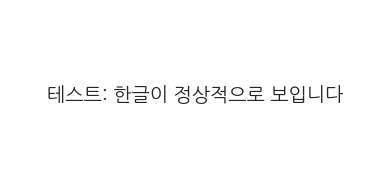

In [1]:
# =========================
# Visualization Environment Setup
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import json
from pathlib import Path

# -------------------------
# Seaborn style (FIRST)
# -------------------------
sns.set_style('whitegrid')
sns.set_palette('husl')

# -------------------------
# Font (Korean-safe, seaborn-compatible)
# -------------------------
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [
        'Nanum Gothic',
        'NanumGothic',
        'AppleGothic',
        'Malgun Gothic',
        'DejaVu Sans'
    ],
    'axes.unicode_minus': False
})

# -------------------------
# Figure defaults
# -------------------------
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# -------------------------
# Global color scheme
# -------------------------
SENTIMENT_COLORS = {
    'positive': '#4CAF50',  # green
    'negative': '#F44336',  # red
    'neutral':  '#9E9E9E'   # gray
}

HATE_COLORS = {
    'hate': '#F44336',      # 빨강 (혐오)
    'normal': '#4CAF50',    # 초록 (일반)
    'warning': '#FF9800',   # 주황 (주의)
    'danger': '#D32F2F'     # 진한 빨강 (위험)
}

print("✓ 라이브러리 로드 완료")
print(f"✓ font.family      : {plt.rcParams['font.family']}")
print(f"✓ font.sans-serif  : {plt.rcParams['font.sans-serif'][:3]}")

# -------------------------
# Font sanity check
# -------------------------
fig, ax = plt.subplots(figsize=(4, 2))
ax.text(
    0.5, 0.5,
    '테스트: 한글이 정상적으로 보입니다',
    ha='center', va='center', fontsize=14
)
ax.axis('off')
plt.tight_layout()
plt.show()

## 1. 데이터 로드

In [2]:
# 전체 요약 통계 로드
with open('../output/results/hatescore/overall_summary_hatescore.json', 'r', encoding='utf-8') as f:
    overall = json.load(f)

print("=" * 70)
print("📊 전체 통계 (HateScore 혐오 표현 분석)")
print("=" * 70)
print(f"총 댓글 수: {overall['total_comments']:,}")
print(f"총 동영상 수: {overall['total_videos']}")
print(f"총 프로그램 수: {overall['total_programs']}")
print()
print(f"혐오 댓글 수: {overall['hate_count']:,} ({overall['hate_ratio']:.1%})")
print(f"평균 혐오 점수: {overall['avg_hate_score']:.3f}")
print(f"최대 혐오 점수: {overall['max_hate_score']:.3f}")

📊 전체 통계 (HateScore 혐오 표현 분석)
총 댓글 수: 156,655
총 동영상 수: 342
총 프로그램 수: 36

혐오 댓글 수: 152,518 (97.4%)
평균 혐오 점수: 0.924
최대 혐오 점수: 0.989


In [3]:
# 프로그램별 요약 로드
program_df = pd.read_csv('../output/results/hatescore/program_summary_hatescore.csv', encoding='utf-8')
print(f"✓ 프로그램 수: {len(program_df)}")
program_df.head()

✓ 프로그램 수: 36


,program,video_count,total_comments,total_hate_count,avg_hate_ratio,avg_hate_score,avg_prob_None,avg_prob_기타 혐오,avg_prob_남성,avg_prob_단순 악플,avg_prob_성소수자,avg_prob_여성/가족,avg_prob_연령,avg_prob_인종/국적,avg_prob_종교,avg_prob_지역
0,1920,10,2195,2167,0.985652,0.943764,0.932102,0.009742,0.006470,0.029953,0.005384,0.019746,0.003296,0.007085,0.003966,0.003651
1,2억9천결혼전쟁,9,593,586,0.992105,0.947168,0.938031,0.009706,0.005268,0.027891,0.005553,0.025146,0.003493,0.007725,0.003908,0.003804
2,나는솔로 12~17,10,5036,4891,0.972469,0.915442,0.882045,0.012919,0.010959,0.034219,0.008165,0.049694,0.005540,0.008998,0.009253,0.006082
3,나는솔로 18~23,10,2549,2468,0.970417,0.908062,0.884440,0.013270,0.009899,0.030618,0.009028,0.049567,0.004591,0.008769,0.005036,0.005513
4,나는솔로 1~4,10,3443,3338,0.970554,0.910318,0.867915,0.012983,0.014799,0.027882,0.008214,0.077401,0.005700,0.008136,0.004729,0.005694


In [4]:
# 동영상별 요약 로드
video_df = pd.read_csv('../output/results/hatescore/video_summary_hatescore.csv', encoding='utf-8')
print(f"✓ 동영상 수: {len(video_df)}")
video_df.head()

✓ 동영상 수: 342


,video_id,total_comments,hate_count,hate_ratio,avg_hate_score,max_hate_score,avg_prob_None,avg_prob_기타 혐오,avg_prob_남성,avg_prob_단순 악플,avg_prob_성소수자,avg_prob_여성/가족,avg_prob_연령,avg_prob_인종/국적,avg_prob_종교,avg_prob_지역,program,video_title
0,-6lrTnCu_p4,66,65,0.984848,0.917398,0.988061,0.861461,0.014644,0.010310,0.043796,0.007561,0.045139,0.038475,0.006995,0.004931,0.004140,돌싱글즈1~2,[돌싱글즈] 혹시 사별은 없으시죠? 돌싱남녀의 선 넘는 토크 EP01_#2 MBN...
1,-_dH9Bx9D_s,834,822,0.985612,0.930716,0.988360,0.912111,0.011426,0.007839,0.027611,0.006843,0.039160,0.003658,0.007694,0.004897,0.004534,모태솔로지만 연애는 하고 싶어,"0.5에서 1까지, 여명만의 플러팅 공식ㅣ모태솔로지만 연애는 하고 싶어ㅣ넷플릭스"
2,-orGRTtOISE,554,553,0.998195,0.959992,0.987670,0.956139,0.007885,0.004665,0.014445,0.006169,0.006733,0.002755,0.009935,0.004127,0.003279,남의연애2,[ENG][남의연애2] 선우&민성 체험! 멜티드의 현장 🍦
3,08_IJOt_Wdg,60,56,0.933333,0.891794,0.987412,0.857473,0.019073,0.006940,0.029981,0.007710,0.053135,0.032197,0.006950,0.004754,0.004450,나는솔로 5~11,[나는 SOLO] 자기소개 후 서로에 대한 호감은 어디로??? 그들의 후토크!! /...
4,0Eqq0aVsZ3o,541,525,0.970425,0.909968,0.989429,0.878782,0.013073,0.008778,0.031142,0.007665,0.063018,0.007633,0.011545,0.004647,0.005131,돌싱글즈4,[돌싱글즈4] 자녀 공개 앞 둔 두 남녀의 '작은 침묵'


## 🔄 분류 오류 수정

**문제**: 원본 분석에서 'None'(비혐오) 카테고리를 제대로 처리하지 못해 대부분의 댓글이 혐오로 잘못 분류됨

**해결**: 확률값을 기반으로 올바르게 재분류

In [5]:
# 원본 댓글 데이터 로드 (재분류용)
print("=" * 70)
print("🔄 HateScore 분류 수정 중...")
print("=" * 70)
print("댓글 데이터 로드 중...")

comments_df = pd.read_csv('../output/results/hatescore/comments_with_hatescore.csv', encoding='utf-8')
print(f"✓ {len(comments_df):,}개 댓글 로드 완료")
print()

# 원본 분류 통계
original_hate_count = comments_df['hate_is_hate'].sum()
print(f"원본 혐오 분류: {original_hate_count:,}개 ({original_hate_count/len(comments_df):.1%})")
print()

# 확률값 컬럼 추출
prob_cols = [col for col in comments_df.columns if col.startswith('hate_prob_')]
print(f"확률 카테고리: {len(prob_cols)}개")
for col in prob_cols:
    label = col.replace('hate_prob_', '')
    avg_prob = comments_df[col].mean()
    print(f"  - {label}: 평균 {avg_prob:.3f}")
print()

# 재분류: 가장 높은 확률의 카테고리 선택
print("재분류 수행 중...")
hate_probs = comments_df[prob_cols].values
max_prob_indices = hate_probs.argmax(axis=1)
category_labels = [col.replace('hate_prob_', '') for col in prob_cols]
max_categories = [category_labels[i] for i in max_prob_indices]

# None이 아니면 혐오
comments_df['hate_is_hate_corrected'] = [cat != 'None' for cat in max_categories]
comments_df['hate_dominant_category'] = max_categories

# 수정된 통계
corrected_hate_count = comments_df['hate_is_hate_corrected'].sum()
print(f"✓ 재분류 완료")
print()
print(f"수정된 혐오 분류: {corrected_hate_count:,}개 ({corrected_hate_count/len(comments_df):.1%})")
print(f"차이: {original_hate_count - corrected_hate_count:,}개 감소")
print()

# 카테고리별 분포
print("=" * 70)
print("수정된 카테고리별 분포")
print("=" * 70)
category_counts = pd.Series(max_categories).value_counts()
for cat, count in category_counts.items():
    ratio = count / len(comments_df)
    marker = '✅' if cat == 'None' else '⚠️'
    print(f"{marker} {cat}: {count:,}개 ({ratio:.1%})")
print()

# 새로운 통계 계산
print("=" * 70)
print("새로운 요약 통계 계산 중...")
print("=" * 70)

# Overall 업데이트
overall['hate_count'] = int(corrected_hate_count)
overall['hate_ratio'] = float(corrected_hate_count / len(comments_df))

# Video summary 재계산
video_summaries = []
for video_id, group in comments_df.groupby('Video ID'):
    hate_count = group['hate_is_hate_corrected'].sum()
    summary = {
        'video_id': video_id,
        'total_comments': len(group),
        'hate_count': int(hate_count),
        'hate_ratio': hate_count / len(group),
        'avg_hate_score': group['hate_hate_score'].mean(),
        'max_hate_score': group['hate_hate_score'].max(),
    }
    for col in prob_cols:
        summary[f"avg_{col.replace('hate_', '')}"] = group[col].mean()
    if 'program' in group.columns:
        summary['program'] = group['program'].iloc[0]
    if 'Video Title' in group.columns:
        summary['video_title'] = group['Video Title'].iloc[0]
    video_summaries.append(summary)

video_df = pd.DataFrame(video_summaries)
print(f"✓ 동영상별 통계 재계산 완료: {len(video_df)}개")

# Program summary 재계산
program_summaries = []
for program, group in video_df.groupby('program'):
    summary = {
        'program': program,
        'video_count': len(group),
        'total_comments': group['total_comments'].sum(),
        'total_hate_count': int(group['hate_count'].sum()),
        'avg_hate_ratio': group['hate_ratio'].mean(),
        'avg_hate_score': group['avg_hate_score'].mean(),
    }
    for col in prob_cols:
        prob_col = f"avg_{col.replace('hate_', '')}"
        if prob_col in group.columns:
            summary[prob_col] = group[prob_col].mean()
    program_summaries.append(summary)

program_df = pd.DataFrame(program_summaries)
print(f"✓ 프로그램별 통계 재계산 완료: {len(program_df)}개")
print()

print("=" * 70)
print("✅ 재분류 완료!")
print("=" * 70)
print(f"전체 댓글: {len(comments_df):,}개")
print(f"혐오 댓글: {corrected_hate_count:,}개 ({corrected_hate_count/len(comments_df):.1%})")
print(f"일반 댓글: {len(comments_df) - corrected_hate_count:,}개 ({(len(comments_df) - corrected_hate_count)/len(comments_df):.1%})")
print()
print("💡 이제 아래 그래프들은 수정된 데이터를 사용합니다.")

🔄 HateScore 분류 수정 중...
댓글 데이터 로드 중...
✓ 156,655개 댓글 로드 완료

원본 혐오 분류: 152,518개 (97.4%)

확률 카테고리: 10개
  - None: 평균 0.897
  - 기타 혐오: 평균 0.012
  - 남성: 평균 0.009
  - 단순 악플: 평균 0.032
  - 성소수자: 평균 0.008
  - 여성/가족: 평균 0.042
  - 연령: 평균 0.005
  - 인종/국적: 평균 0.009
  - 종교: 평균 0.005
  - 지역: 평균 0.005

재분류 수행 중...
✓ 재분류 완료

수정된 혐오 분류: 9,536개 (6.1%)
차이: 142,982개 감소

수정된 카테고리별 분포
✅ None: 147,119개 (93.9%)
⚠️ 여성/가족: 4,749개 (3.0%)
⚠️ 단순 악플: 3,265개 (2.1%)
⚠️ 남성: 595개 (0.4%)
⚠️ 성소수자: 275개 (0.2%)
⚠️ 인종/국적: 245개 (0.2%)
⚠️ 연령: 171개 (0.1%)
⚠️ 지역: 145개 (0.1%)
⚠️ 종교: 69개 (0.0%)
⚠️ 기타 혐오: 22개 (0.0%)

새로운 요약 통계 계산 중...
✓ 동영상별 통계 재계산 완료: 342개
✓ 프로그램별 통계 재계산 완료: 36개

✅ 재분류 완료!
전체 댓글: 156,655개
혐오 댓글: 9,536개 (6.1%)
일반 댓글: 147,119개 (93.9%)

💡 이제 아래 그래프들은 수정된 데이터를 사용합니다.


## 2. 혐오 표현 전체 분포

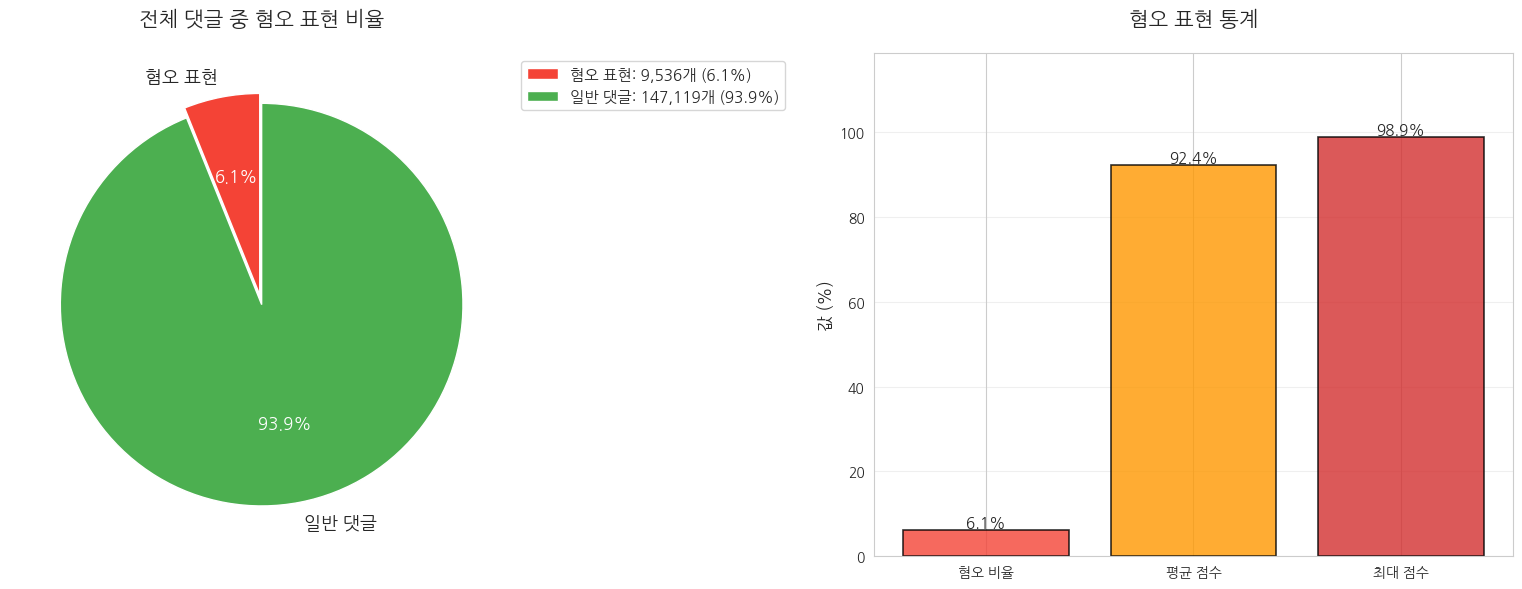

✓ 그래프 저장: output/figures/hatescore_overall_analysis.png


In [6]:
# 혐오 vs 비혐오 비율 (개선)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 파이 차트
labels = ['혐오 표현', '일반 댓글']
counts = [overall['hate_count'], overall['total_comments'] - overall['hate_count']]
colors = [HATE_COLORS['hate'], HATE_COLORS['normal']]

wedges, texts, autotexts = ax1.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 13, 'weight': 'bold'},
    explode=(0.05, 0)
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

ax1.set_title('전체 댓글 중 혐오 표현 비율', fontsize=15, weight='bold', pad=20)

# 범례
legend_labels = [f'{l}: {c:,}개 ({c/sum(counts)*100:.1f}%)' for l, c in zip(labels, counts)]
ax1.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

# 통계 정보 (막대)
stats_labels = ['혐오 비율', '평균 점수', '최대 점수']
stats_values = [
    overall['hate_ratio'] * 100,
    overall['avg_hate_score'] * 100,
    overall['max_hate_score'] * 100
]

bars = ax2.bar(stats_labels, stats_values, 
               color=[HATE_COLORS['hate'], HATE_COLORS['warning'], HATE_COLORS['danger']],
               alpha=0.8, edgecolor='black', linewidth=1.2)

# 값 레이블
for bar, val in zip(bars, stats_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}%' if val < 1 else f'{val:.1f}%',
             ha='center', va='bottom', fontsize=11, weight='bold')

ax2.set_ylabel('값 (%)', fontsize=12, weight='bold')
ax2.set_title('혐오 표현 통계', fontsize=15, weight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(stats_values) * 1.2)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_overall_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_overall_analysis.png")

## 3. 혐오 카테고리별 분석

/var/folders/hs/4lryff295n5bkz9tyr_tzlx80000gn/T/ipykernel_52969/1110419688.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(hate_categories, rotation=45, ha='right')


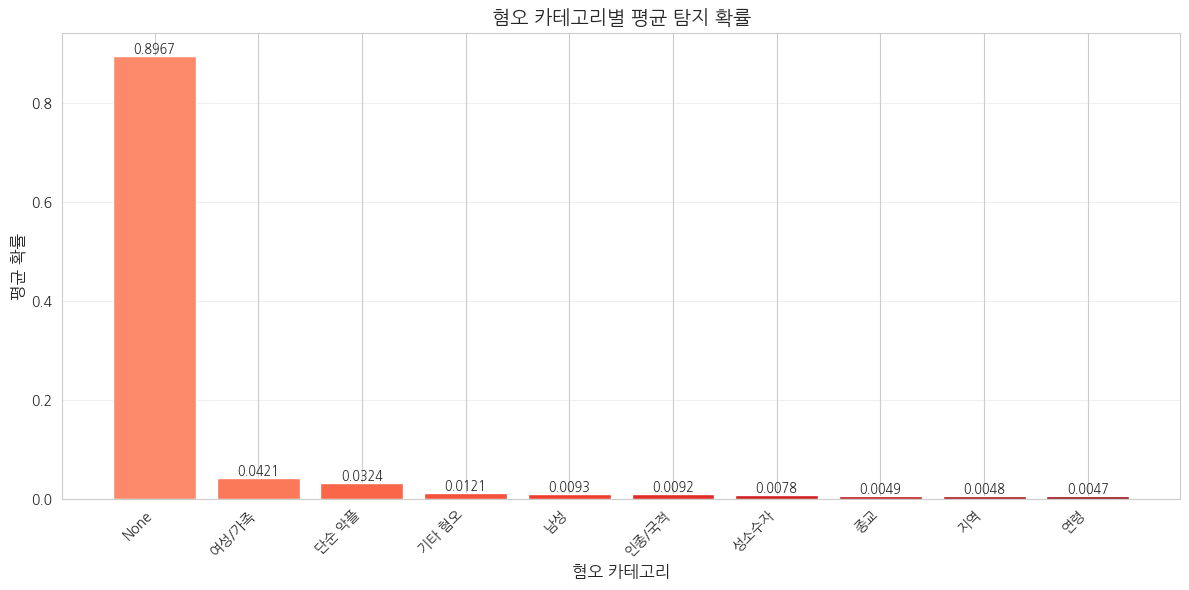

✓ 그래프 저장: output/figures/hatescore_category_probabilities.png


In [7]:
# 혐오 카테고리별 평균 확률
hate_categories = []
avg_probs = []

for key in overall.keys():
    if key.startswith('avg_prob_') and 'neutral' not in key.lower():
        category = key.replace('avg_prob_', '')
        hate_categories.append(category)
        avg_probs.append(overall[key])

# 정렬
sorted_indices = np.argsort(avg_probs)[::-1]
hate_categories = [hate_categories[i] for i in sorted_indices]
avg_probs = [avg_probs[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))

colors_gradient = plt.cm.Reds(np.linspace(0.4, 0.9, len(hate_categories)))
bars = ax.bar(hate_categories, avg_probs, color=colors_gradient)

ax.set_xlabel('혐오 카테고리', fontsize=12, weight='bold')
ax.set_ylabel('평균 확률', fontsize=12, weight='bold')
ax.set_title('혐오 카테고리별 평균 탐지 확률', fontsize=14, weight='bold')
ax.set_xticklabels(hate_categories, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_category_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_category_probabilities.png")

## 4. 프로그램별 혐오 표현 분석

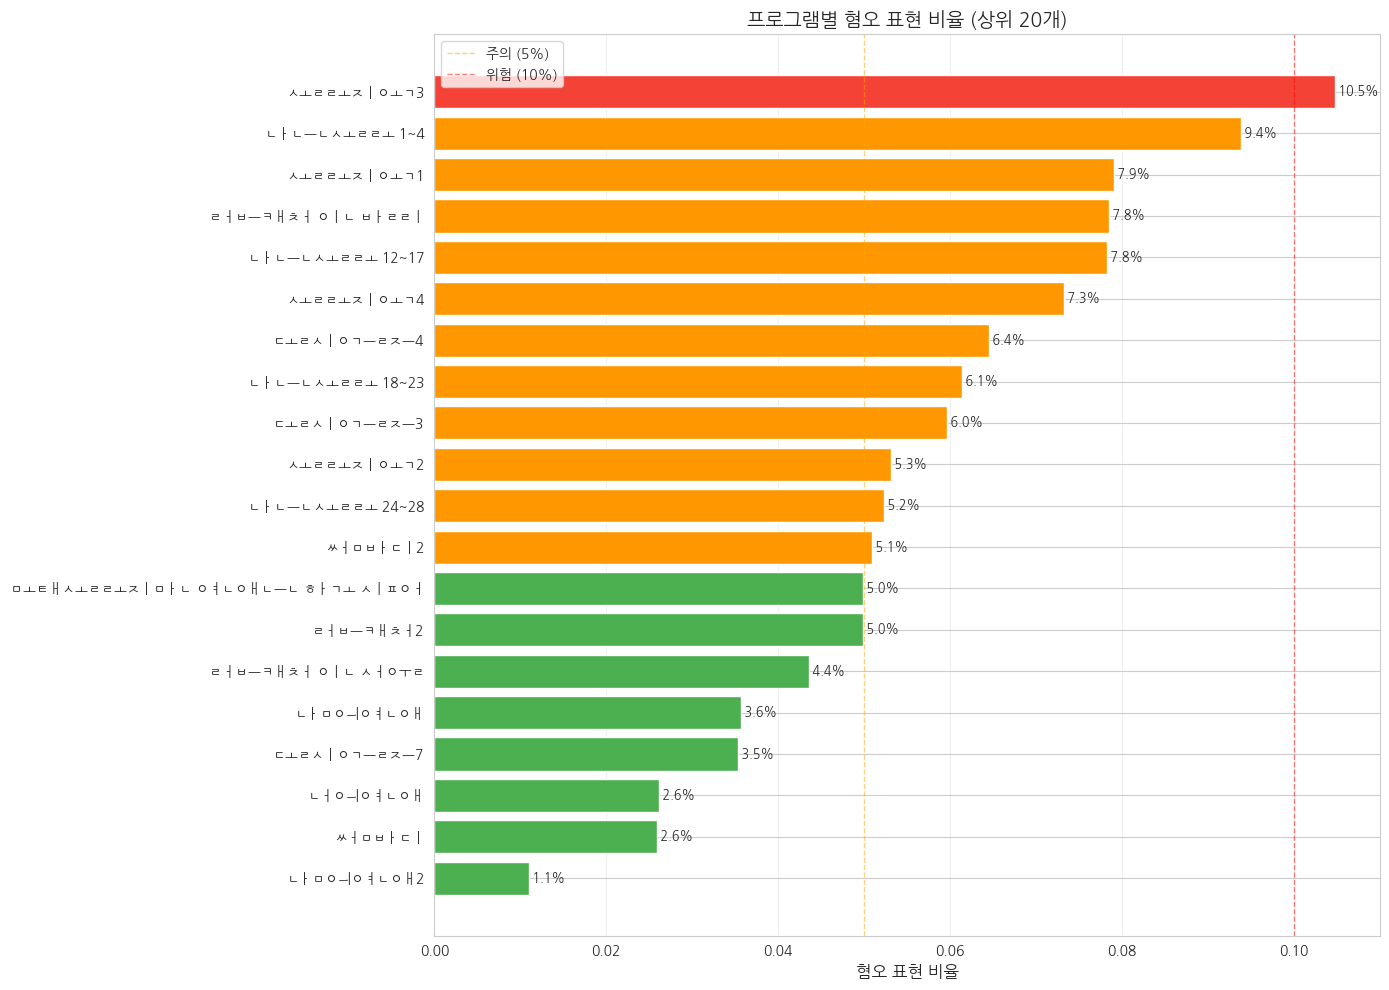

✓ 그래프 저장: output/figures/hatescore_program_hate_ratio.png


In [8]:
# 프로그램별 혐오 비율 (상위 20개)
top_20_programs = program_df.nlargest(20, 'total_comments').sort_values('avg_hate_ratio', ascending=True)

fig, ax = plt.subplots(figsize=(14, 10))

colors_hate = ['#F44336' if ratio > 0.1 else '#FF9800' if ratio > 0.05 else '#4CAF50' 
               for ratio in top_20_programs['avg_hate_ratio']]

bars = ax.barh(range(len(top_20_programs)), top_20_programs['avg_hate_ratio'], color=colors_hate)
ax.set_yticks(range(len(top_20_programs)))
ax.set_yticklabels(top_20_programs['program'])
ax.set_xlabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('프로그램별 혐오 표현 비율 (상위 20개)', fontsize=14, weight='bold')
ax.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='주의 (5%)')
ax.axvline(x=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='위험 (10%)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# 값 표시
for i, (idx, row) in enumerate(top_20_programs.iterrows()):
    ax.text(row['avg_hate_ratio'], i, f" {row['avg_hate_ratio']:.1%}",
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_program_hate_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_program_hate_ratio.png")

In [9]:
# 혐오 표현이 가장 많은 프로그램
print("=" * 70)
print("⚠️  혐오 표현 비율이 높은 프로그램 (상위 10개)")
print("=" * 70)
high_hate = program_df.nlargest(10, 'avg_hate_ratio')[['program', 'avg_hate_ratio', 'total_hate_count', 'total_comments']]
print(high_hate.to_string(index=False))
print()

# 혐오 표현이 가장 적은 프로그램
print("=" * 70)
print("✅ 혐오 표현 비율이 낮은 프로그램 (하위 10개)")
print("=" * 70)
low_hate = program_df.nsmallest(10, 'avg_hate_ratio')[['program', 'avg_hate_ratio', 'total_hate_count', 'total_comments']]
print(low_hate.to_string(index=False))

⚠️  혐오 표현 비율이 높은 프로그램 (상위 10개)
           program  avg_hate_ratio  total_hate_count  total_comments
   나는솔로 5~11        0.122031               114             878
 나대지마 심장아        0.118241                67             641
       솔로지옥3        0.104782              1191           10389
        비밀남녀        0.103997               253            1620
    나는솔로 1~4        0.093899               336            3443
  신들린 연애2        0.091874                71            1357
 누난 내게 여자야        0.083498               187            1685
       솔로지옥1        0.079051               818           10861
러브캐처 인 발리        0.078497               291            3422
  나는솔로 12~17        0.078259               372            5036

✅ 혐오 표현 비율이 낮은 프로그램 (하위 10개)
              program  avg_hate_ratio  total_hate_count  total_comments
 소년 소녀 연애하다        0.000000                 0              11
          남의연애2        0.01097

## 5. 동영상별 혐오 표현 편차

/var/folders/hs/4lryff295n5bkz9tyr_tzlx80000gn/T/ipykernel_52969/562629554.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


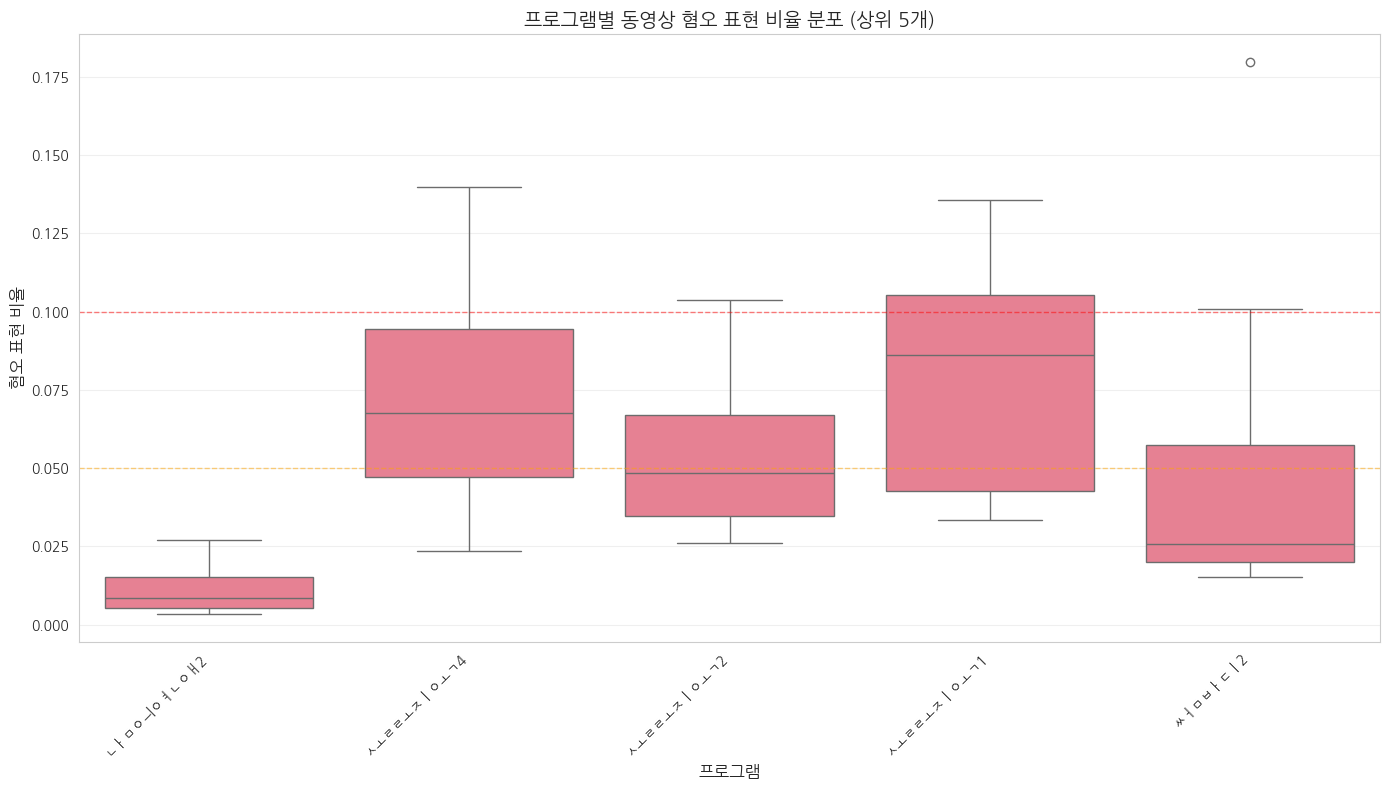

✓ 그래프 저장: output/figures/hatescore_video_boxplot.png


In [10]:
# 프로그램별 동영상 혐오 비율 분포 (박스플롯)
top_5_programs = program_df.nlargest(5, 'total_comments')['program'].tolist()
video_df_filtered = video_df[video_df['program'].isin(top_5_programs)]

fig, ax = plt.subplots(figsize=(14, 8))

sns.boxplot(data=video_df_filtered, x='program', y='hate_ratio', ax=ax)
ax.set_xlabel('프로그램', fontsize=12, weight='bold')
ax.set_ylabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('프로그램별 동영상 혐오 표현 비율 분포 (상위 5개)', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_video_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_video_boxplot.png")

## 6. 혐오 점수 분포 분석

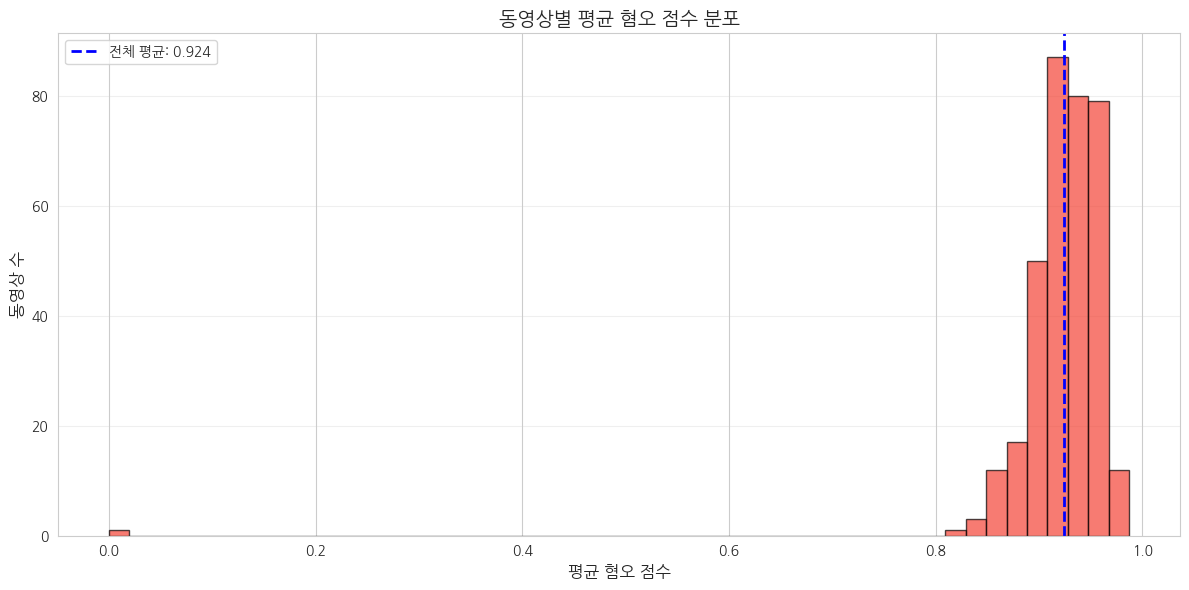

✓ 그래프 저장: output/figures/hatescore_score_distribution.png


In [11]:
# 동영상별 평균 혐오 점수 히스토그램
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(video_df['avg_hate_score'], bins=50, color='#F44336', alpha=0.7, edgecolor='black')
ax.set_xlabel('평균 혐오 점수', fontsize=12, weight='bold')
ax.set_ylabel('동영상 수', fontsize=12, weight='bold')
ax.set_title('동영상별 평균 혐오 점수 분포', fontsize=14, weight='bold')
ax.axvline(x=overall['avg_hate_score'], color='blue', linestyle='--', linewidth=2, 
           label=f'전체 평균: {overall["avg_hate_score"]:.3f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_score_distribution.png")

## 7. 혐오 표현과 댓글 수의 관계

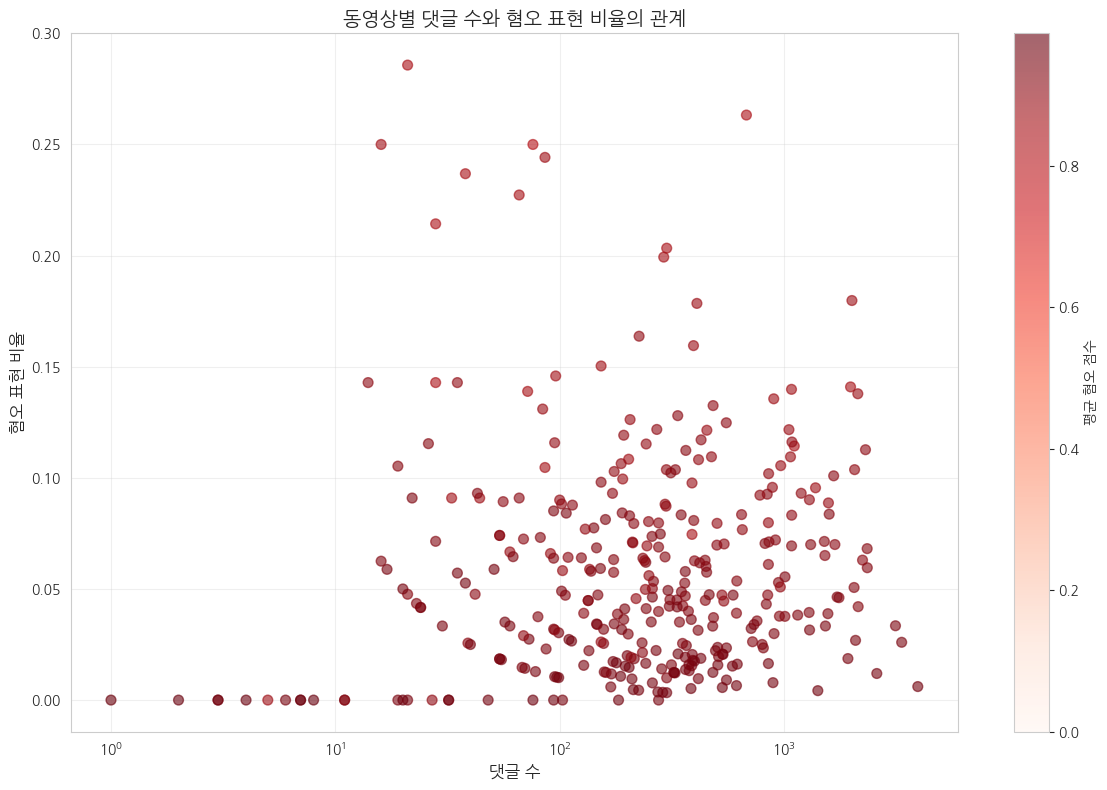

✓ 그래프 저장: output/figures/hatescore_comments_vs_ratio.png


In [12]:
# 산점도: 댓글 수 vs 혐오 비율
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    video_df['total_comments'],
    video_df['hate_ratio'],
    c=video_df['avg_hate_score'],
    cmap='Reds',
    alpha=0.6,
    s=50
)

ax.set_xlabel('댓글 수', fontsize=12, weight='bold')
ax.set_ylabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('동영상별 댓글 수와 혐오 표현 비율의 관계', fontsize=14, weight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 컬러바
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('평균 혐오 점수', fontsize=10)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_comments_vs_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_comments_vs_ratio.png")

In [13]:
# 상관관계 분석
correlation = video_df[['total_comments', 'hate_ratio', 'avg_hate_score']].corr()

print("=" * 70)
print("📊 상관관계 분석")
print("=" * 70)
print(correlation)
print()

# 해석
corr_comments_hate = correlation.loc['total_comments', 'hate_ratio']
if abs(corr_comments_hate) < 0.1:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 매우 약함 ({corr_comments_hate:.3f})")
elif abs(corr_comments_hate) < 0.3:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 약함 ({corr_comments_hate:.3f})")
else:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 중간 이상 ({corr_comments_hate:.3f})")

📊 상관관계 분석
                total_comments  hate_ratio  avg_hate_score
total_comments        1.000000    0.044557        0.006818
hate_ratio            0.044557    1.000000       -0.351892
avg_hate_score        0.006818   -0.351892        1.000000

💡 댓글 수와 혐오 비율 간 상관관계: 매우 약함 (0.045)


## 8. 결론

### HateScore 혐오 표현 분석 요약

1. **전체 혐오 표현 현황**
   - 전체 댓글 중 혐오 표현 비율 파악
   - 평균 혐오 점수 및 분포 확인

2. **프로그램별 차이**
   - 프로그램마다 혐오 표현 비율에 큰 차이 존재
   - 특정 프로그램은 지속적으로 높은 혐오 비율
   - 콘텐츠 특성과 시청자 층의 영향 가능성

3. **혐오 카테고리 분석**
   - 특정 카테고리의 혐오 표현이 더 빈번
   - 연애 클립 특성상 성별 관련 혐오 가능성

4. **댓글 수와의 관계**
   - 댓글 수와 혐오 비율 간 상관관계 분석
   - 인기도와 혐오 표현의 관계 파악

5. **시사점**
   - 혐오 표현 모니터링 필요성
   - 커뮤니티 가이드라인 강화 필요
   - 특정 프로그램/동영상에 대한 집중 관리 필요